<a href="https://colab.research.google.com/github/jyoti-chn/Appartment-Complex-Reccomendation-System/blob/main/K_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import numpy as np
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

#analysing
file_path = '/content/cleaned_housing_data.csv'
housing_data = pd.read_csv(file_path)

housing_data.head()


,Unnamed: 0,area_type,availability,location,size,total_sqft,bath,balcony,price
0,0,Super built-up Area,0,Electronic City Phase II,2.0,1056.0,2.0,1.0,39.07
1,2,Built-up Area,1,Uttarahalli,3.0,1440.0,2.0,3.0,62.00
2,3,Super built-up Area,1,Lingadheeranahalli,3.0,1521.0,3.0,1.0,95.00
3,4,Super built-up Area,1,Kothanur,2.0,1200.0,2.0,1.0,51.00
4,5,Super built-up Area,1,Whitefield,2.0,1170.0,2.0,1.0,38.00


In [ ]:
user_preferences = {
    'max_budget': 1000,
    'min_bedrooms': 0,
    'min_bathrooms': 0,
    'min_balconies': 0
}

def convert_sqft_to_num(x):
    tokens = str(x).split('-')
    if len(tokens) == 2:
        # print(x)
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

housing_data['total_sqft'] = housing_data['total_sqft'].apply(convert_sqft_to_num)

housing_data.dropna(subset=['total_sqft'], inplace=True)
housing_data.rename(columns={'size': 'bedrooms'}, inplace=True)

features = ['bedrooms', 'total_sqft', 'bath', 'balcony']

filtered_data = housing_data[
        (housing_data['price'] <= user_preferences['max_budget']) &
        (housing_data['bedrooms'] >= user_preferences['min_bedrooms']) &
        (housing_data['bath'] >= user_preferences['min_bathrooms']) &
        (housing_data['balcony'] >= user_preferences['min_balconies'])
    ]

#K-means
weights = {'bedrooms': 2, 'total_sqft': 3, 'price':3 ,'bath': 1, 'balcony' : 1}
for feature, weight in weights.items():
    filtered_data[feature + '_weighted'] = filtered_data[feature] * weight


weighted_features = ['bedrooms_weighted', 'total_sqft_weighted', 'price_weighted', 'bath_weighted', 'balcony_weighted']

X = StandardScaler().fit_transform(filtered_data[weighted_features])

wcss = []

# Determine the range of K values to evaluate
k_values = range(3, 11)  # Adjust the range as needed

# Calculate WCSS and silhouette score for each value of K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    wcss.append(kmeans.inertia_)



# Determine the optimal K using the Elbow Method programmatically
optimal_k = find_optimal_k(wcss)
print("Optimal number of clusters (K) using elbow method:", optimal_k)

# Plot the Elbow Method
plt.figure(figsize=(12, 6))

# Plot WCSS
plt.subplot(1, 2, 1)
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-cluster sum of squares (WCSS)')


plt.tight_layout()
plt.show()






/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 4
Cluster 1: 3779 data points
Cluster 2: 3355 data points
Cluster 0: 3247 data points
Cluster 3: 735 data points


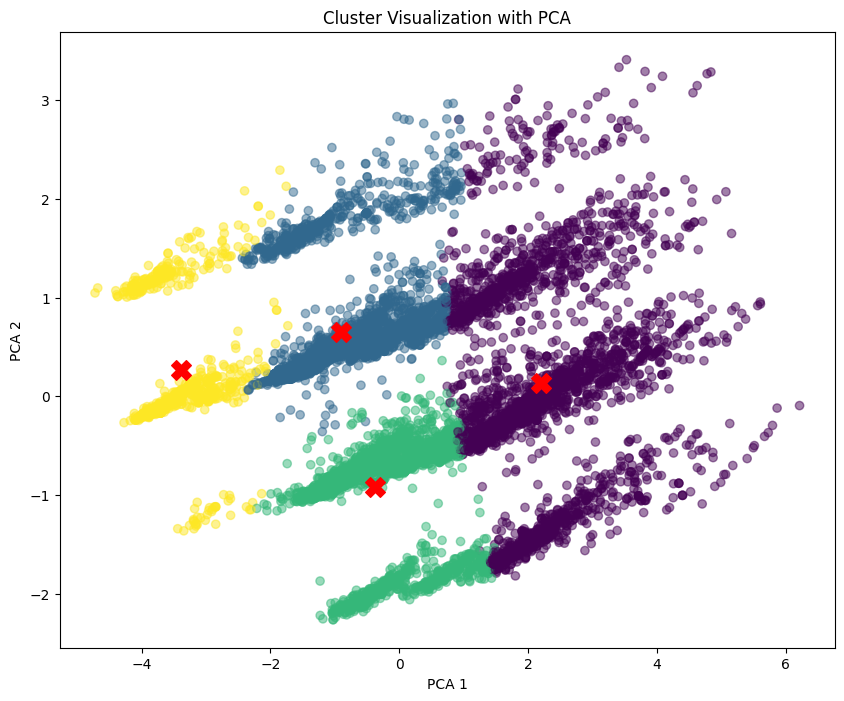

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
filtered_data['cluster'] = kmeans.fit_predict(X)

unique_clusters = np.unique(kmeans.labels_)
print("Number of clusters:", len(unique_clusters))
cluster_labels = kmeans.labels_
cluster_counts = Counter(cluster_labels)
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} data points")


#2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


cluster_assignments = kmeans.labels_

plt.figure(figsize=(10, 8))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments, cmap='viridis', marker='o', alpha=0.5)


centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Cluster Visualization with PCA')
plt.show()

In [ ]:
def recommend_apartments():
    filtered_data['price_per_sqft'] = filtered_data['price'] * 100000 / filtered_data['total_sqft']
    recommendations = filtered_data.sort_values(['cluster', 'price_per_sqft'], ascending=[True, True])

    #top 5 recommendations for each cluster
    top_recommendations = recommendations.groupby('cluster').head(5)
    return top_recommendations

top_recommendations = recommend_apartments()
print_recommendations= top_recommendations.drop(['bedrooms_weighted', 'total_sqft_weighted', 'bath_weighted', 'balcony_weighted', 'price_weighted', 'price_per_sqft', 'availability'], axis=1)
print_recommendations

,Unnamed: 0,area_type,location,bedrooms,total_sqft,bath,balcony,price,cluster
9796,11748,Built-up Area,Begur,3.0,2400.0,3.0,2.0,12.000,0
2035,2421,Plot Area,Basavanagara,4.0,2000.0,3.0,2.0,25.000,0
487,579,Plot Area,Sarjapur Road,2.8,1800.0,2.8,1.4,34.185,0
9526,11426,Super built-up Area,Channasandra Layout,3.0,2400.0,2.0,3.0,50.000,0
1870,2223,Plot Area,Nelamangala,4.0,1470.0,4.0,2.0,34.500,0
9644,11569,Plot Area,Hosur Road,2.2,1350.0,2.0,1.0,8.440,1
9197,11019,Plot Area,Yelahanka,1.6,1500.0,1.8,1.2,12.750,1
6937,8306,Plot Area,Anekal,1.8,1453.0,2.0,1.4,16.500,1
2362,2809,Plot Area,Sarjapur Road,2.2,1800.0,2.6,1.0,28.785,1
5611,6719,Plot Area,Hoskote,1.6,1730.0,1.8,1.4,28.545,1
